<font face="Calibri" size="2"> <i>SBAE - Notebook Series - Part I, version 0.3,  May 2023. Andreas Vollrath, Daniel Wiell, Javier Garcia-Perez, Laura D'Aietti, Remi D'Annunzio - UN-Food and Agricultural Organization, Rome</i>
</font>

![titre](images/header.png)

# I - Pré-analyse
### Statistiques sur les forêts et la déforestation, la taille de l'échantillon et le calcul et la simulation des erreurs
-------


Ce cahier fournit du code et des fonctions pour l'extraction de certaines informations de base sur les statistiques forestières pour une zone d'intérêt donnée ainsi que la taille de l'échantillon et les calculs d'erreur. Il est structuré dans les parties suivantes :
    
1. Statistiques sur la superficie forestière et la déforestation selon le produit Global Forest Change ([Hansen et al 2013](https://10.1126/science.1244693))
2. Taille théorique de l'échantillon et calcul d'erreur selon Cochran pour capturer les événements de déforestation
3. Simulation de l'erreur d'échantillonnage basée sur le produit Global Forest Change

La plupart des données et fonctionnalités proviennent de [Google Earth Engine](https://earthengine.google.com), pour lequel vous aurez besoin d'un compte valide. Il est possible de s'inscrire librement [ici](https://code.earthengine.google.com/register).

## Introduction aux blocs-notes eSBAE (utilisateurs novices, lisez attentivement)

Les cahiers E-SBAE sont une série de cahiers Jupyter destinés à rationaliser le processus de création de données d'activité pour la mesure, la notification et la vérification de la REDD+ et d'autres normes carbone.

E-SBAE est principalement basé sur la bibliothèque Python du gestionnaire d'échantillonnage qui fournit toutes les fonctionnalités sous-jacentes nécessaires. Alors que les cahiers vous évitent la lourde charge de coder chaque élément, vous n'aurez qu'à déclarer quelques variables d'entrée de base qui définissent vos besoins personnalisés. Cela signifie que vous **n'avez pas besoin** d'être un programmeur python expérimenté, mais une compréhension de base aide.

Vous remarquerez que la structure de chaque notebook est assez similaire, seuls les paramétrages s'adaptant à l'étape en cours. Vous pouvez également utiliser des parties individuelles à des fins spécifiques, mais parcourir chacun des cahiers consécutivement garantit la meilleure façon d'exécuter en douceur l'ensemble du processus.

Deux éléments relient les sorties de chaque bloc-notes : le ***nom du projet*** et un ***fichier de configuration*** sous-jacent. Cela facilite non seulement l'interaction, mais garantit également la transparence, la reproductibilité et l'interaction entre les différentes étapes/cahiers.

In [1]:
import ee 
# initialize EE    
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

from sampling_handler import SampleSize

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.8/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### 1 - Réglages des paramètres de base

Dans la cellule suivante, vous définirez certains des paramètres clés pour créer les statistiques forestières suivantes.

1. Nom du projet : non seulement cela donnera un nom à votre travail, mais cela définira également le dossier de sortie dans le module_results/esbae (si vous êtes sur SEPAL), ainsi qu'un répertoire dans vos ressources Earth Engine. **NOTEZ** qu'il ne doit pas contenir d'espace.

2. Zone d'intérêt (AOI) : Votre AOI définit l'étendue spatiale pour laquelle les données seront générées et analysées. Il peut se présenter sous différents formats, tels qu'une collection d'entités Earth Engine (filtrée), un format de données géospatiales compatible OGR (par exemple, Shapefile, Geopackage, KML, GeoJSON) ou un objet géopandas GeoDataFrame.

3. Les années de début et de fin définiront l'étendue temporelle pour laquelle les zones de déforestation sont extraites du produit GFC. Cette zone sera finalement utilisée pour déterminer la taille de l'échantillonnage en fonction de l'équation de Cochran.

4. Couvert arboré et mmu déterminent par quels seuils le produit GFC sera filtré afin de considérer un (ensemble de) pixels comme forêt. Les valeurs sont définies en pourcentage et en hectare.

In [2]:
# Here goes your project's name (without spaces)
project_name = 'esbae_congo'

# Area of Interest (various options, e.g. shapefile, geodataframe, ee FeatureCollection)
# Example uses a filtered Earth Egnine Feature Collection
country = 'Congo'
gaul = ee.FeatureCollection("FAO/GAUL/2015/level1")
aoi = gaul.filter(ee.Filter.eq("ADM0_NAME", country)).union()

# envisaged FREL/change assessment period (years are inclusive)
start_year = 2016       # YYYY format
end_year = 2021         # YYYY format

# forest definition
tree_cover = 10         # in percentage
mmu = 0.5               # in hectare 

### 2 - initialisation de l'instance de la classe Sample Size

Il s'agit de mettre à jour le fichier de configuration, rien n'a besoin d'être changé ici.

In [3]:
esbae = SampleSize(
    project_name=project_name,
    aoi=aoi,
    start=start_year,
    end=end_year,
    tree_cover=tree_cover,
    mmu=mmu
)

INFO: Using existing project directory at /home/sepal-user/module_results/esbae/esbae_congo
INFO: Using existent config file from project directory /home/sepal-user/module_results/esbae/esbae_congo


### 3 - Extraire la superficie forestière et la déforestation annuelle

#### 3.1 Utilisation du produit Global Forest Change

En utilisant la routine suivante, la superficie forestière sera déterminée en fonction de l'année de début et du pourcentage de couvert arboré. Les statistiques de pertes de couvert arboré sont tirées de la période qui s'étend entre le début et la fin de l'année.

INFO: Extracting areas of forest and deforestation from Hansen's Global Forest Change product. This may take a moment...


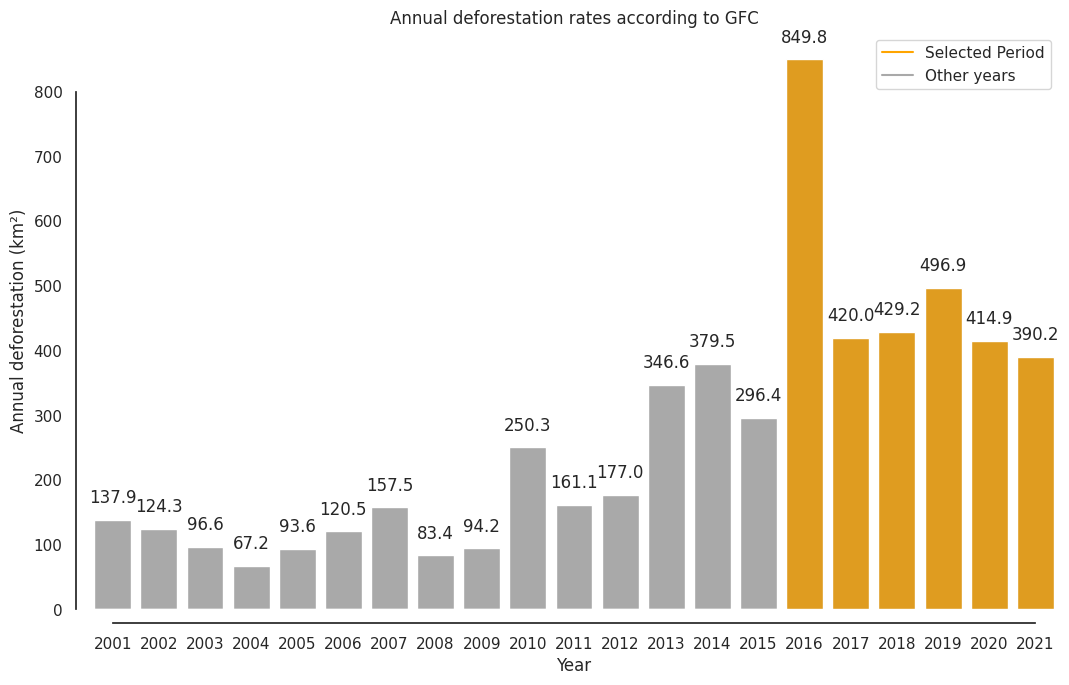

In [4]:
# get area statistics from Hansen's GFC data from Google Earth Engine
esbae.gfc_areas(save_figure=True)

### 4. Calcul de la taille de l'échantillon selon Cochran

En fournissant une erreur cible et un intervalle de confiance, la taille minimale de l'échantillon est calculée sur la base des statistiques sur la superficie forestière créées ci-dessus. Le calcul est effectué à la fois pour la superficie forestière et pour l'évolution de la forêt, sur la base de la formule de Cochran pour la taille de l'échantillon ([Cochran 1963](https://onlinelibrary.wiley.com/doi/10.1002/zamm.19630431039)).

#### 4.1 - Calculer la marge d'erreur et l'espacement des grilles

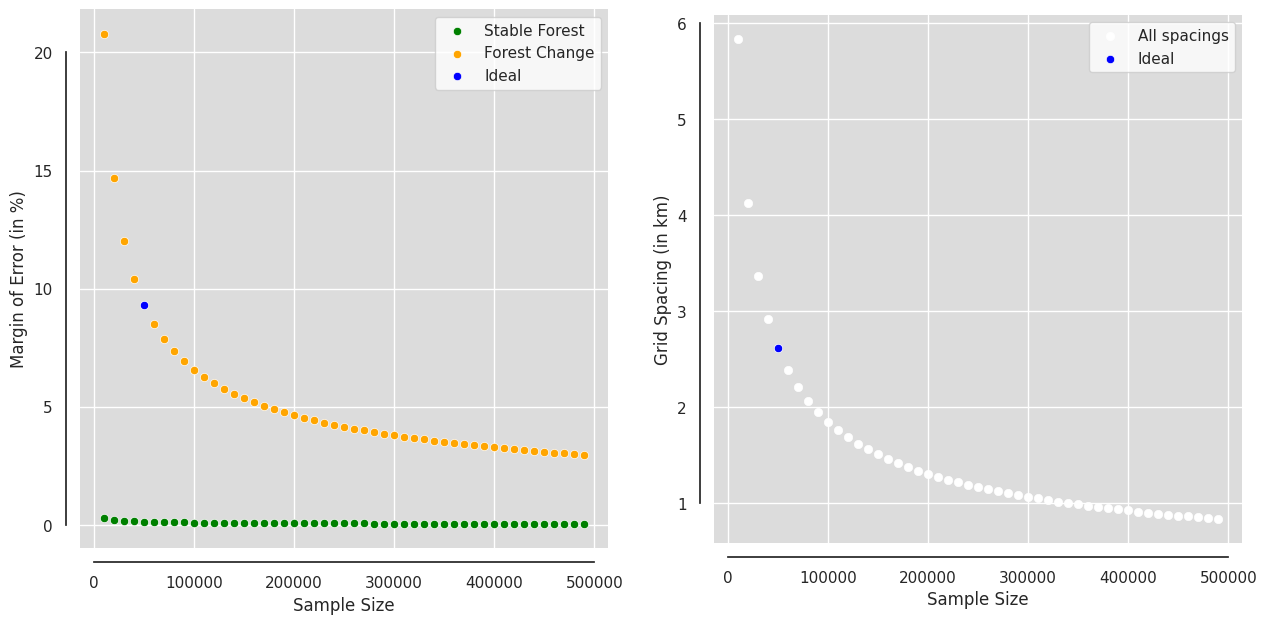

In [5]:
esbae.target_error = 10     # in percentage
esbae.confidence = 95    # in percentage

esbae.minimum_sample_size(save_figure=True)

### 5 - Simulation des erreurs d'échantillonnage (biais et incertitude)

INFO: Running the sampling error simulation. This can take a while...


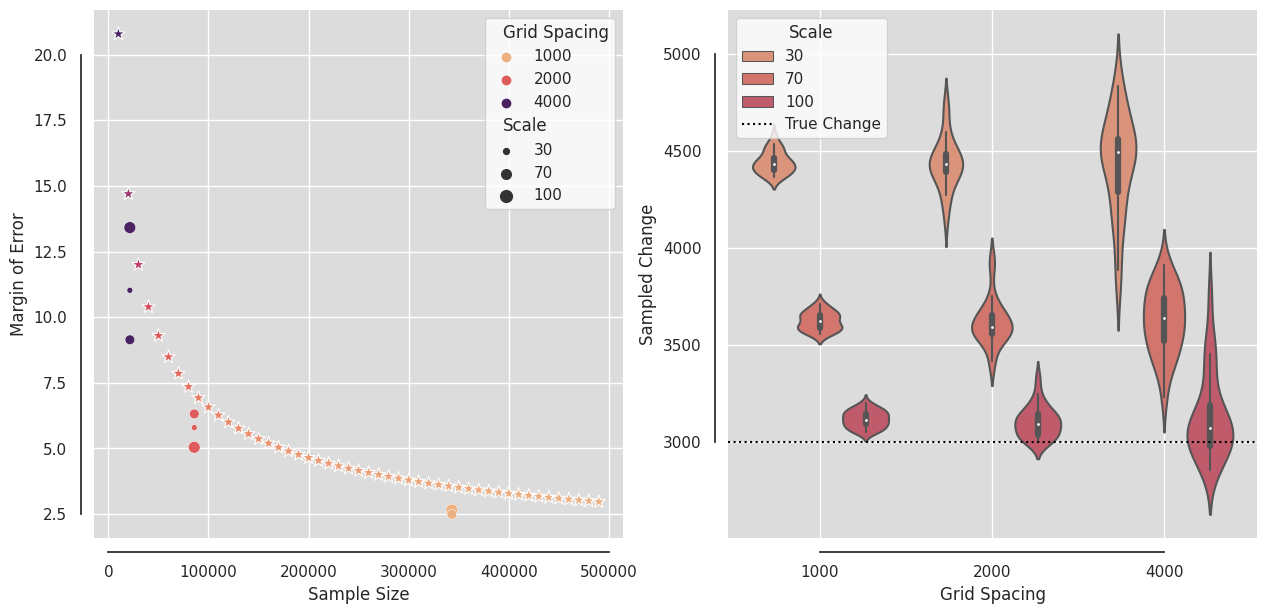

In [6]:
esbae.spacings =    [1000, 2000, 4000]      # grid spacings to simulate
esbae.scales =      [30, 70, 100]            # mmus to simulate
esbae.runs =        25                           # nr of times a each simulation is run
esbae.random_seed = 42                           # a random seed for reproducability

esbae.simulated_sampling_error(save_figure=True)